In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [2]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=7, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        e2 = self.bn2(self.conv2(bn1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
        e5 = self.bn5(self.conv5(e2))
        e6 = self.conv6(e5)

        return e6

In [3]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [41]:
tensor = np.load("../2015-5appliances-true-agg.npy")

In [44]:
residual = tensor[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()

In [48]:
new_tensor = np.hstack((tensor, residual))

In [49]:
np.save("../2015-5appliances-true-agg-residual.npy", new_tensor)

In [67]:
torch.manual_seed(0)
num_folds = 5
dataset = 3
fold_num = 0
lr = 0.1
origin_train, origin_test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [68]:
# create the residual column
train_residual = origin_train[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
train = np.hstack((origin_train, train_residual))

In [69]:
# create the residual column
test_residual = origin_test[:, 1:6, :, :].sum(axis=1).reshape(-1, 1, 112, 24).copy()
test = np.hstack((origin_test, test_residual))

In [70]:
APPLIANCE_ORDER=['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw', 'residual']

In [71]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [73]:
# ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
ORDER = ['fridge', 'dr', 'hvac', 'residual', 'dw', 'mw']
# ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [74]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [75]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [76]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [77]:
valid_aggregate.shape

(11, 1, 112, 24)

In [78]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [79]:
p = 0
num_iterations = 20000
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 500 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 1000 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward()
    optimizer.step()



Round: 500 Training Error: 115.6749496459961 Validation Error: 138.5467071533203 Test Error: 116.1715087890625
Round: 1000 Training Error: 106.35627746582031 Validation Error: 136.62225341796875 Test Error: 122.078857421875
Round: 1500 Training Error: 99.11601257324219 Validation Error: 137.44192504882812 Test Error: 123.20746612548828
Round: 2000 Training Error: 97.36116790771484 Validation Error: 137.97918701171875 Test Error: 122.91264343261719
Round: 2500 Training Error: 94.81021118164062 Validation Error: 138.9236297607422 Test Error: 123.39470672607422
Round: 3000 Training Error: 93.70829010009766 Validation Error: 141.29171752929688 Test Error: 125.4384536743164
Round: 3500 Training Error: 93.60761260986328 Validation Error: 140.40921020507812 Test Error: 124.49886322021484
Round: 4000 Training Error: 92.6692123413086 Validation Error: 141.77088928222656 Test Error: 125.20233154296875
Round: 4500 Training Error: 92.33757019042969 Validation Error: 142.51443481445312 Test Error: 

In [80]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

In [81]:
threshold = {'dr': 18.233293339770761, 'dw': 11.704597207156935, 'mw': 1.2877147226060413}

In [82]:
from sklearn.metrics import mean_absolute_error

train_fold = {}
for t in range(1000, num_iterations + 1, 1000):
    train_pred[t] = torch.split(train_pred[t], train_aggregate.shape[0])
    train_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].data.numpy().reshape(-1, 24)
            
valid_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

In [83]:
# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

train_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    train_gt_fold[appliance_num] = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        train_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(1000, num_iterations + 1, 1000):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        if appliance in ['hvac', 'fridge', 'residual']:
            valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])
        else:
            valid_error[t][appliance] = onoff_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num], threshold[appliance])

test_error = {}
for t in range(1000, num_iterations + 1, 1000):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        if appliance in ['hvac', 'fridge', 'residual']: 
            test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])
        else:
            test_error[t][appliance] = onoff_error(test_fold[t][appliance_num], test_gt_fold[appliance_num], threshold[appliance])
        
train_error = {}
for t in range(1000, num_iterations + 1, 1000):
    train_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        if appliance in ['hvac', 'fridge', 'residual']:
            train_error[t][appliance] = mean_absolute_error(train_fold[t][appliance_num], train_gt_fold[appliance_num])
        else:
            train_error[t][appliance] = onoff_error(train_fold[t][appliance_num], train_gt_fold[appliance_num], threshold[appliance])

In [84]:
import pandas as pd
pd.DataFrame(test_error)

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000
dr,1121.268228,770.697704,433.784467,433.650199,429.992058,433.638220,428.346816,432.372318,428.316575,425.034532,425.642943,428.593859,424.192012,424.437756,429.150737,424.387195,426.381056,421.471912,422.162995,419.669443
dw,317.337600,317.134726,317.133115,317.668190,317.122602,317.909683,317.134726,317.542411,317.134726,317.514244,317.370421,317.335215,317.134602,317.134702,317.134612,317.134640,317.529474,317.369415,317.133254,317.132877
fridge,44.753378,47.048829,44.934818,45.096040,45.208390,45.523562,45.517421,45.372403,45.601908,45.465562,45.570026,45.410036,45.378651,45.395261,45.795598,45.680777,45.514575,45.388366,45.601938,45.533138
hvac,271.131207,278.054685,278.577676,279.877340,278.946904,279.856829,278.494428,276.348089,277.523270,278.423347,275.162218,274.447398,276.922382,275.551068,275.981923,277.519340,275.961839,276.742645,275.817517,276.005030
mw,10.260526,10.185792,10.246561,10.246249,10.248167,10.207568,10.145244,10.182635,10.315704,10.278624,10.230779,10.341016,10.336734,10.380691,10.344232,10.304049,10.318051,10.184112,10.310039,10.280635
residual,335.051788,321.204356,326.901479,322.257895,321.114951,318.881128,320.565863,315.158671,318.505414,323.532904,319.593870,314.736839,324.379069,325.412694,317.863924,320.508201,321.341840,329.083681,325.352593,330.264212


In [29]:
import pandas as pd
pd.DataFrame(test_error)

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000
dr,385.812052,385.703982,387.040523,385.135113,385.752109,384.534366,383.814401,386.981293,385.516144,389.343729,388.439150,389.339992,382.767271,388.545182,386.550419,383.939396,387.215062,387.084563,381.234602,378.391200
dw,317.133873,317.134025,317.134726,317.133534,317.133546,317.133907,317.133571,317.134592,317.134603,317.134726,317.134726,317.129882,317.134258,317.133544,317.133147,317.133426,317.134077,317.134726,317.134685,317.134314
fridge,44.727441,44.766444,45.050374,45.044448,45.159236,45.095458,45.152605,45.180204,45.171693,45.360562,45.208024,45.288097,45.093829,45.290316,45.266321,45.221810,45.269006,45.342230,45.244328,45.332631
hvac,291.677255,293.114751,295.013577,296.211133,296.416736,297.188956,295.645983,295.266890,294.171844,295.779399,294.761939,295.079289,292.671205,297.396065,293.787471,297.387773,296.647710,295.553011,296.187924,297.363023
mw,10.421192,10.519169,10.734011,10.580958,10.614997,10.659907,10.695380,10.635415,10.608906,10.719662,10.630683,10.625710,10.697750,10.576889,10.575543,10.671312,10.649717,10.408573,10.383634,10.392366
residual,335.021802,336.908462,337.219743,332.772608,332.556227,334.245580,336.436527,333.491729,332.917255,334.696032,334.042270,332.854876,333.648317,332.824116,335.758092,333.217517,333.080222,333.470806,333.057987,334.637721


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [28]:
test_fold[1000][0].max()

108.58198

In [29]:
test_gt_fold[0].max()

784.0999755859375

In [30]:
pd.DataFrame(test_error)

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000
dr,82.112811,82.188149,82.207058,82.150044,82.175100,82.276483,82.285912,82.199145,82.115086,82.052060,82.119077,82.133185,82.244156,82.256503,82.252106,82.326351,82.378387,82.479128,82.403778,82.457864
dw,20.695032,20.688002,20.638440,20.637366,20.631612,20.630548,20.627828,21.257624,20.706249,20.669071,20.629656,20.629570,20.626531,20.627159,20.630278,20.629285,21.280872,20.633611,20.644212,20.631964
fridge,36.338381,36.394982,36.847273,36.830246,36.871933,36.852271,36.472683,36.493716,36.452510,36.938386,36.380798,36.577765,36.541647,36.592443,36.897675,36.727391,36.636382,36.524685,36.429124,36.422355
hvac,355.888631,356.215885,355.372398,355.480004,355.043829,354.939694,354.908141,354.943438,354.952836,354.687968,355.408553,354.560042,354.573350,354.510415,354.421086,354.583197,354.392222,354.164121,353.775384,353.732531
mw,6.282431,6.372191,6.569840,6.821187,6.988669,7.227715,7.418542,7.667397,7.665165,7.740932,7.723783,7.567517,7.471776,7.399424,7.333692,7.210790,7.119218,7.088269,7.033304,7.003582
residual,409.258616,408.154391,409.597734,405.982040,403.956221,400.338427,405.524470,408.174462,403.024043,402.809158,406.632175,404.686992,407.924601,402.626445,403.065121,402.487910,403.069527,407.967568,403.804505,410.369816


In [ ]:
pd.DataFrame(test_fold[1000][2]).T.plot()

In [31]:
test_aggregate.shape

(13, 1, 112, 24)

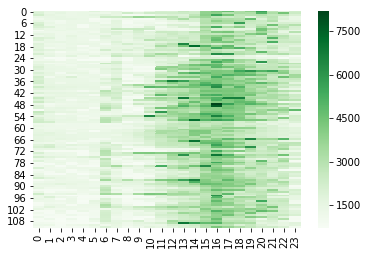

In [32]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

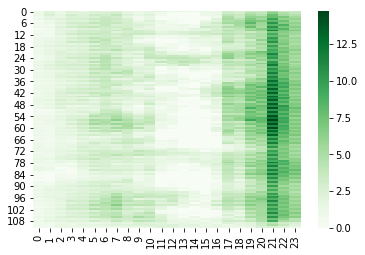

In [68]:
sns.heatmap(pd.DataFrame(test_fold[10000][0].reshape(-1, 112, 24)[10]), cmap='Greens')

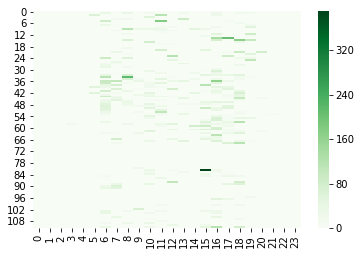

In [67]:
sns.heatmap(pd.DataFrame(test_gt_fold[0].reshape(-1, 112, 24)[10]), cmap='Greens')

In [69]:
pd.DataFrame(test_error)

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000
dr,81.322050,81.280898,81.275294,81.366892,81.257932,81.231062,81.270020,81.206673,81.198876,81.206855,81.197558,81.218912,81.151517,81.121782,81.075602,81.011093,81.037244,80.983303,80.978631,80.926146
dw,22.031705,21.899985,22.039262,20.647875,21.756704,21.842812,21.714740,21.623826,21.630875,21.661090,21.768200,21.683417,21.687946,21.801296,21.848434,21.749764,20.804462,21.574685,21.647982,21.704142
fridge,36.054220,36.024769,36.068336,35.984145,36.051666,36.149465,36.175622,36.343910,36.372061,36.422549,36.518917,36.625403,36.629940,36.519647,36.559390,36.669150,36.936669,36.472792,36.522956,36.552529
hvac,359.296394,358.931006,359.186108,360.464432,359.811764,359.692230,358.193511,359.190176,357.384998,357.478925,357.793700,357.772169,358.130174,356.932884,356.000820,357.342196,357.030594,356.581968,355.709500,355.563728
mw,6.434547,6.510926,6.511832,6.552428,6.535311,6.540996,6.498136,6.538925,6.532652,6.556635,6.593817,6.561046,6.575517,6.564861,6.538966,6.562644,6.531795,6.495291,6.510350,6.513135
residual,422.451713,422.170178,416.133231,421.618155,419.947868,424.222891,421.877289,424.749416,429.325638,431.690262,444.350991,437.104537,442.550920,444.713729,449.506763,454.048492,453.241212,455.781456,465.331470,473.357599


In [70]:
test_error

{1000: {'dr': 81.32205036373017,
  'dw': 22.031704636340837,
  'fridge': 36.054219562402324,
  'hvac': 359.29639448463996,
  'mw': 6.4345468134166639,
  'residual': 422.45171318107873},
 2000: {'dr': 81.280898478511673,
  'dw': 21.899984569587829,
  'fridge': 36.024768559812891,
  'hvac': 358.93100585771759,
  'mw': 6.5109258646896189,
  'residual': 422.17017752696739},
 3000: {'dr': 81.275294424102768,
  'dw': 22.039262022714173,
  'fridge': 36.068335926765535,
  'hvac': 359.18610809552092,
  'mw': 6.5118324969915022,
  'residual': 416.13323106903158},
 4000: {'dr': 81.366891872408686,
  'dw': 20.647875419210706,
  'fridge': 35.98414475870581,
  'hvac': 360.46443167746975,
  'mw': 6.5524279949693023,
  'residual': 421.61815515388588},
 5000: {'dr': 81.257931739263412,
  'dw': 21.756704200352942,
  'fridge': 36.051666488597853,
  'hvac': 359.81176352237964,
  'mw': 6.535311410560392,
  'residual': 419.94786840511989},
 6000: {'dr': 81.231062300794406,
  'dw': 21.842812423590402,
  'fri